In [1]:
### IMPORTS ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
import glob
import sys
import pdb
from dataset_characterization import dataset_characterization
import matplotlib.gridspec as gridspec
import config


outputdir = "C:\\Files\\UM\\ND\\SFN"
preprocessingdir = os.path.join("C:\\Files\\UM\\ND\\SFN","preprocessing_092024_no7822nofalcon")
characterizationdir = outputdir
perf_dir = 'C:\\Files\\UM\\ND\\big_nhp_dataset_code\\sfn_stuff' #dir to sfn_stuff

In [2]:
df = pd.read_csv(os.path.join(outputdir, 'channelwise_stability_tuning.csv'))
print(df)

             date  channel  magnitude       angle
0      2020-01-27        0   0.143947   57.805588
1      2020-01-27        1   0.058501   56.621729
2      2020-01-27        2   0.151813   46.046582
3      2020-01-27        3   0.071023   92.921169
4      2020-01-27        4   0.043333  -78.980063
...           ...      ...        ...         ...
36955  2024-02-05       91   0.001958   43.645215
36956  2024-02-05       92   0.003359   14.123641
36957  2024-02-05       93   0.003158  -83.542574
36958  2024-02-05       94   0.000821 -101.286072
36959  2024-02-05       95   0.000836   40.480941

[36960 rows x 4 columns]


             date  channel  magnitude       angle
42     2020-01-27       42   0.120841 -121.071624
138    2020-01-30       42   0.119105 -127.364525
234    2020-02-04       42   0.061926 -121.746635
330    2020-02-05       42   0.053838  -80.056156
426    2020-02-06       42   0.050152 -106.020955
...           ...      ...        ...         ...
36522  2023-11-02       42   0.037470 -135.634152
36618  2023-12-11       42   0.057798  -76.662284
36714  2023-12-13       42   0.008136  -61.826771
36810  2024-01-16       42   0.050411 -104.418793
36906  2024-02-05       42   0.001782  -75.600533

[385 rows x 4 columns]


C:\Users\chang\AppData\Local\Temp\ipykernel_17416\696060253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_data['date'] = pd.to_datetime(channel_data['date'])


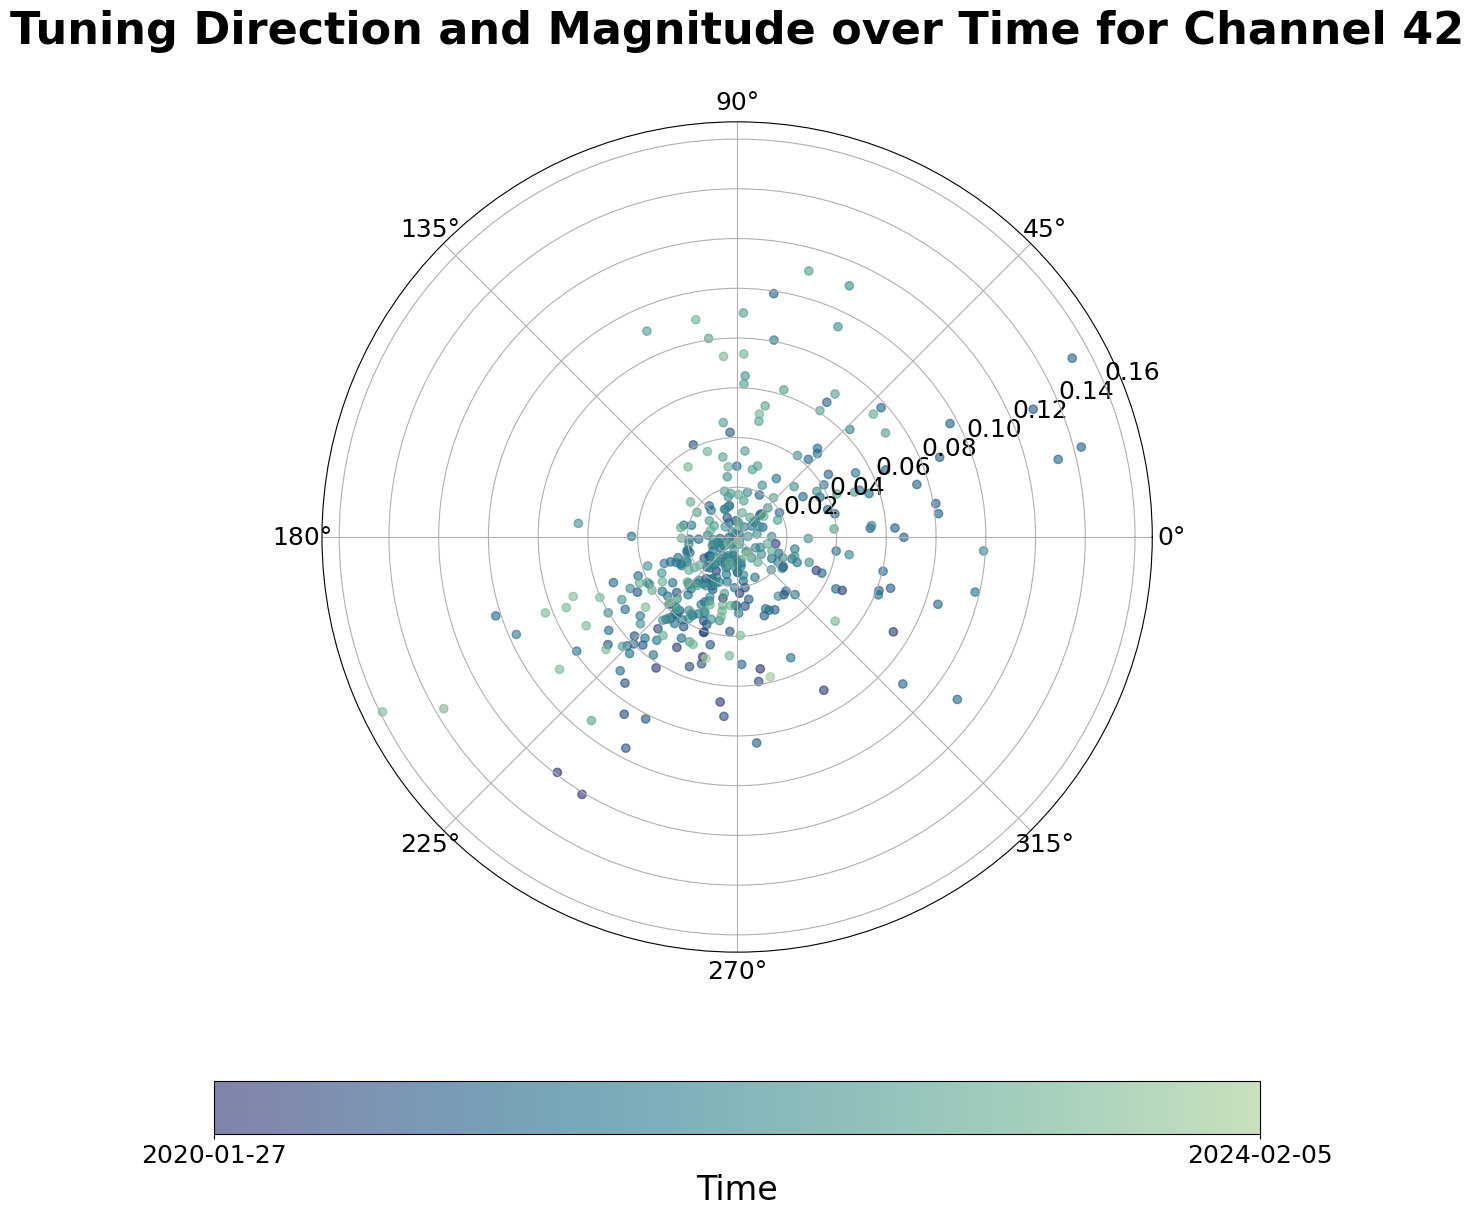

In [3]:
channel_number = 42
channel_data = df[df['channel'] == channel_number]

print(channel_data)

channel_data['date'] = pd.to_datetime(channel_data['date'])
time_normalized = (channel_data['date'] - channel_data['date'].min()) / (channel_data['date'].max() - channel_data['date'].min())

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12, 12))

# the good looking colour map
cmap = sns.color_palette('crest', as_cmap=True).reversed()

# the current colour map i used to see it clearer
#cmap = sns.color_palette('coolwarm', as_cmap=True)

scatter = ax.scatter(
    np.radians(channel_data['angle']),
    channel_data['magnitude'],
    c=time_normalized,
    cmap=cmap,
    alpha=0.6
)
cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Time')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([channel_data['date'].min().strftime('%Y-%m-%d'), channel_data['date'].max().strftime('%Y-%m-%d')])
ax.set_title(f'Tuning Direction and Magnitude over Time for Channel {channel_number}', va='bottom', pad=50)
plt.show()


In [9]:
matrix = df.pivot(index='channel', columns='date', values='magnitude')
print(matrix)

date     2020-01-27  2020-01-30  2020-02-04  2020-02-05  2020-02-06  \
channel                                                               
0          0.143947    0.115039    0.131083    0.082829    0.085917   
1          0.058501    0.070292    0.073618    0.044300    0.059508   
2          0.151813    0.172516    0.182409    0.135110    0.147158   
3          0.071023    0.121204    0.079812    0.072199    0.110612   
4          0.043333    0.046146    0.052541    0.055465    0.025312   
...             ...         ...         ...         ...         ...   
91         0.042414    0.047006    0.031741    0.039773    0.014772   
92         0.014226    0.015322    0.012400    0.028112    0.010624   
93         0.061720    0.043634    0.055833    0.042189    0.042138   
94         0.016404    0.025921    0.019561    0.024827    0.014070   
95         0.032606    0.028315    0.023156    0.029551    0.035843   

date     2020-02-22  2020-02-24  2020-02-25  2020-02-28  2020-03-02  ...  \


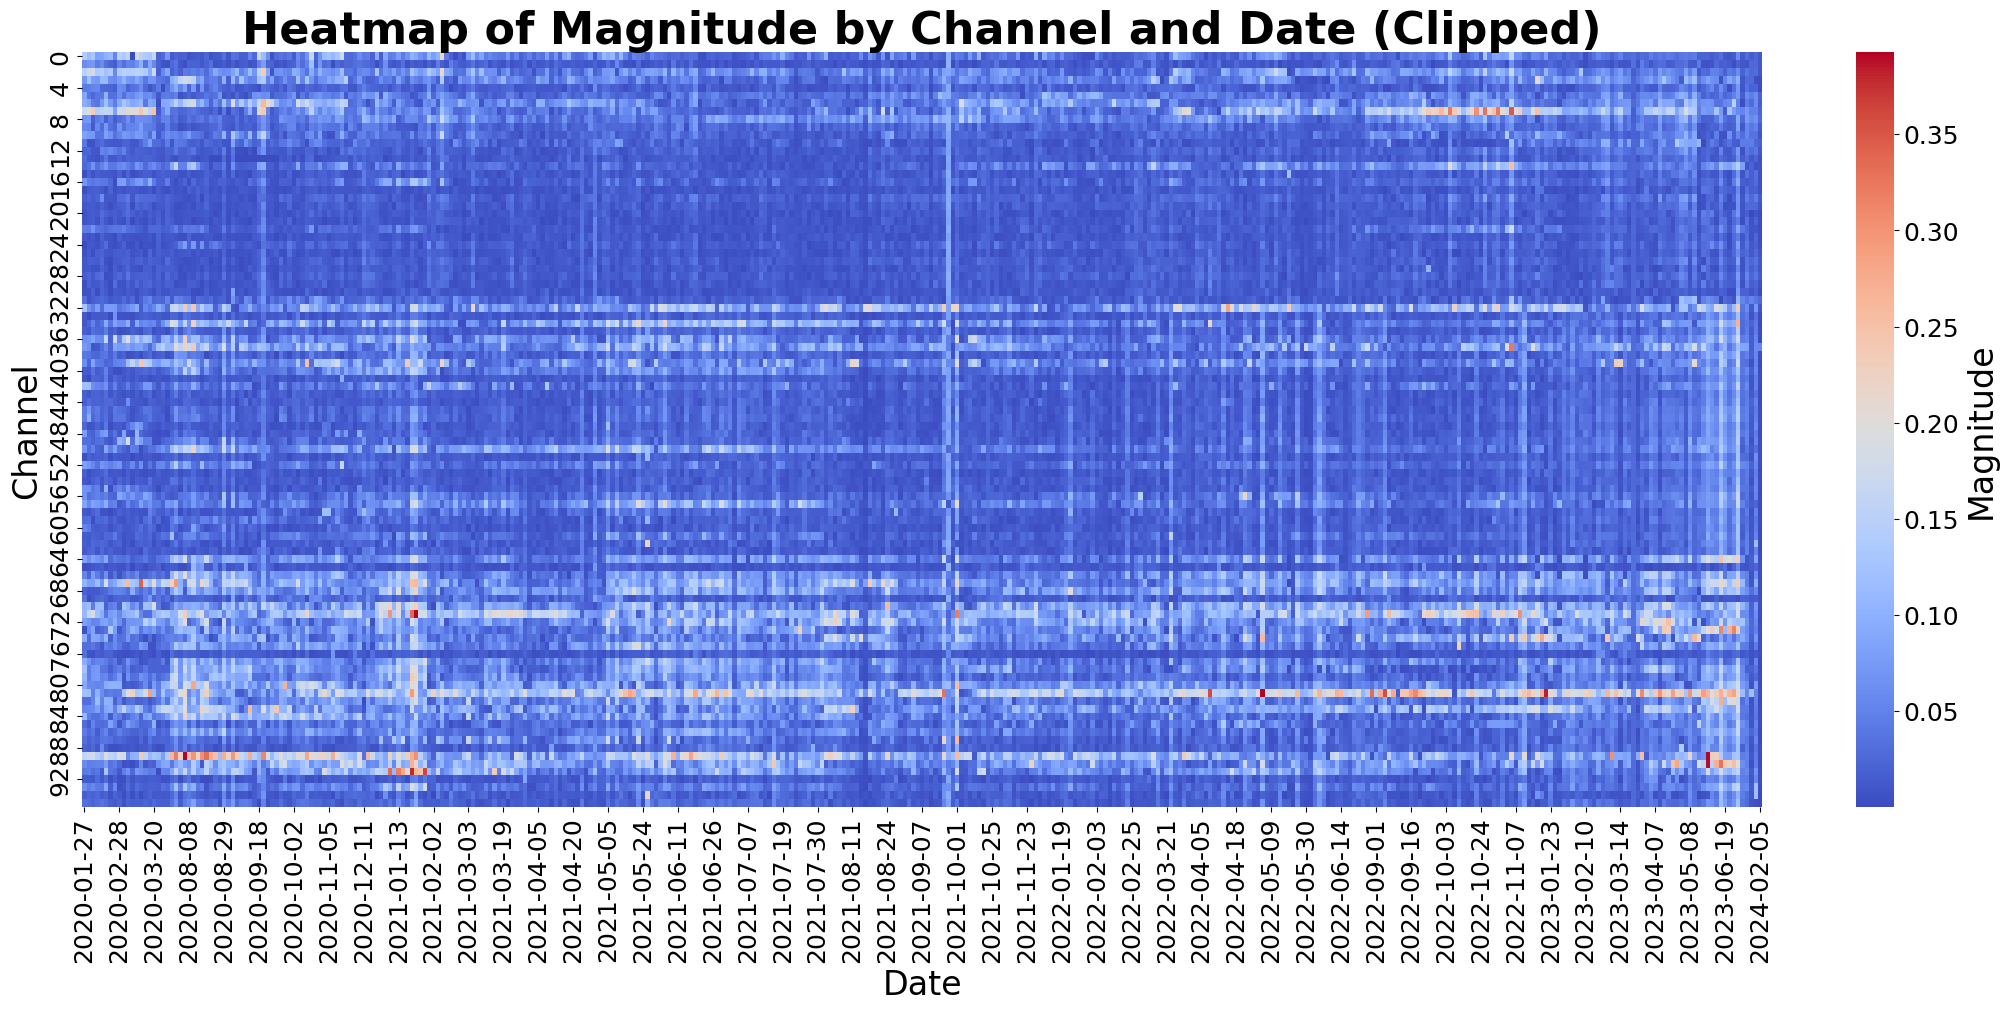

In [ ]:
lower_bound = matrix.quantile(0.01).min()
upper_bound = matrix.quantile(0.99).max()
clipped_matrix = matrix.clip(lower=lower_bound, upper=upper_bound)

plt.figure(figsize=(20, 10))
sns.heatmap(clipped_matrix, cmap='coolwarm', cbar_kws={'label': 'Magnitude'})
plt.title('Heatmap of Magnitude by Channel and Date (Clipped)')
plt.xlabel('Date')
plt.ylabel('Channel')
plt.show()

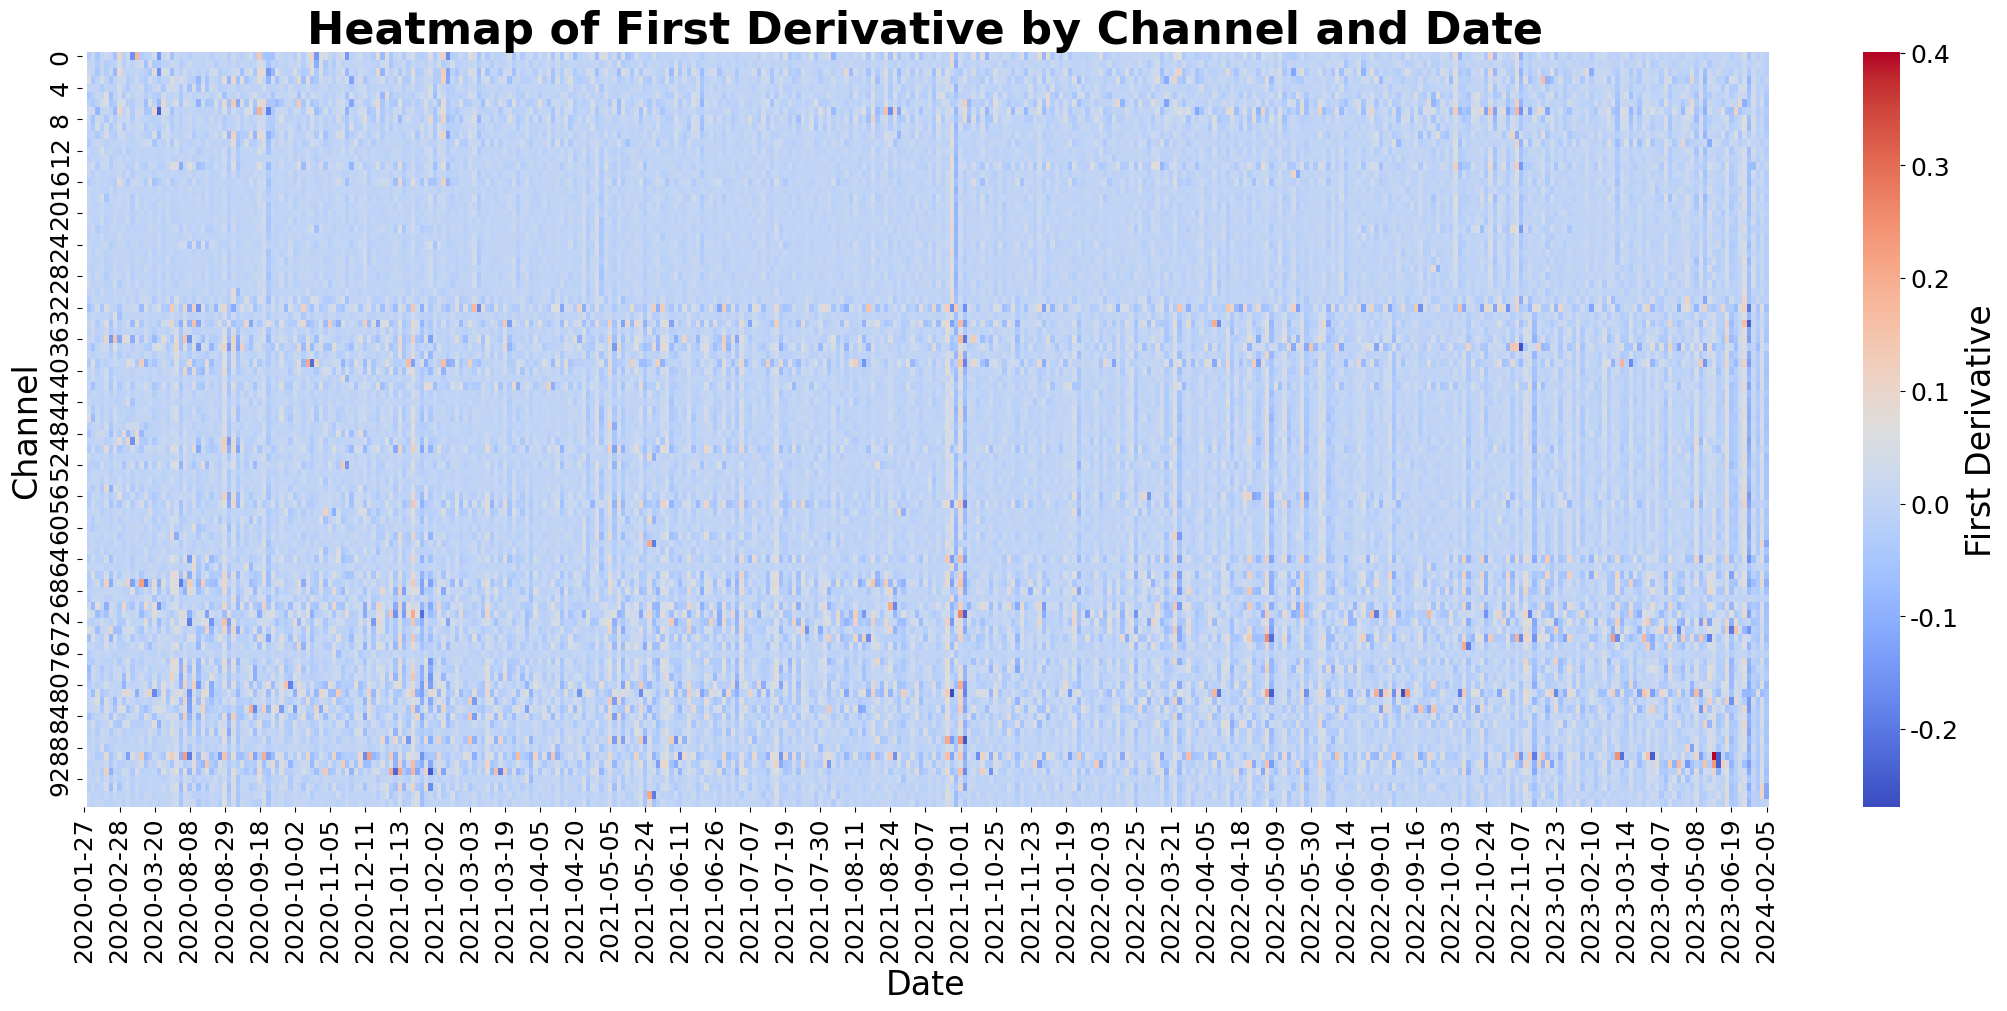

In [ ]:
first_derivative = matrix.diff(axis=1)
plt.figure(figsize=(20, 10))
sns.heatmap(first_derivative, cmap='coolwarm', cbar_kws={'label': 'First Derivative'})
plt.title('Heatmap of First Derivative by Channel and Date')
plt.xlabel('Date')
plt.ylabel('Channel')
plt.show()

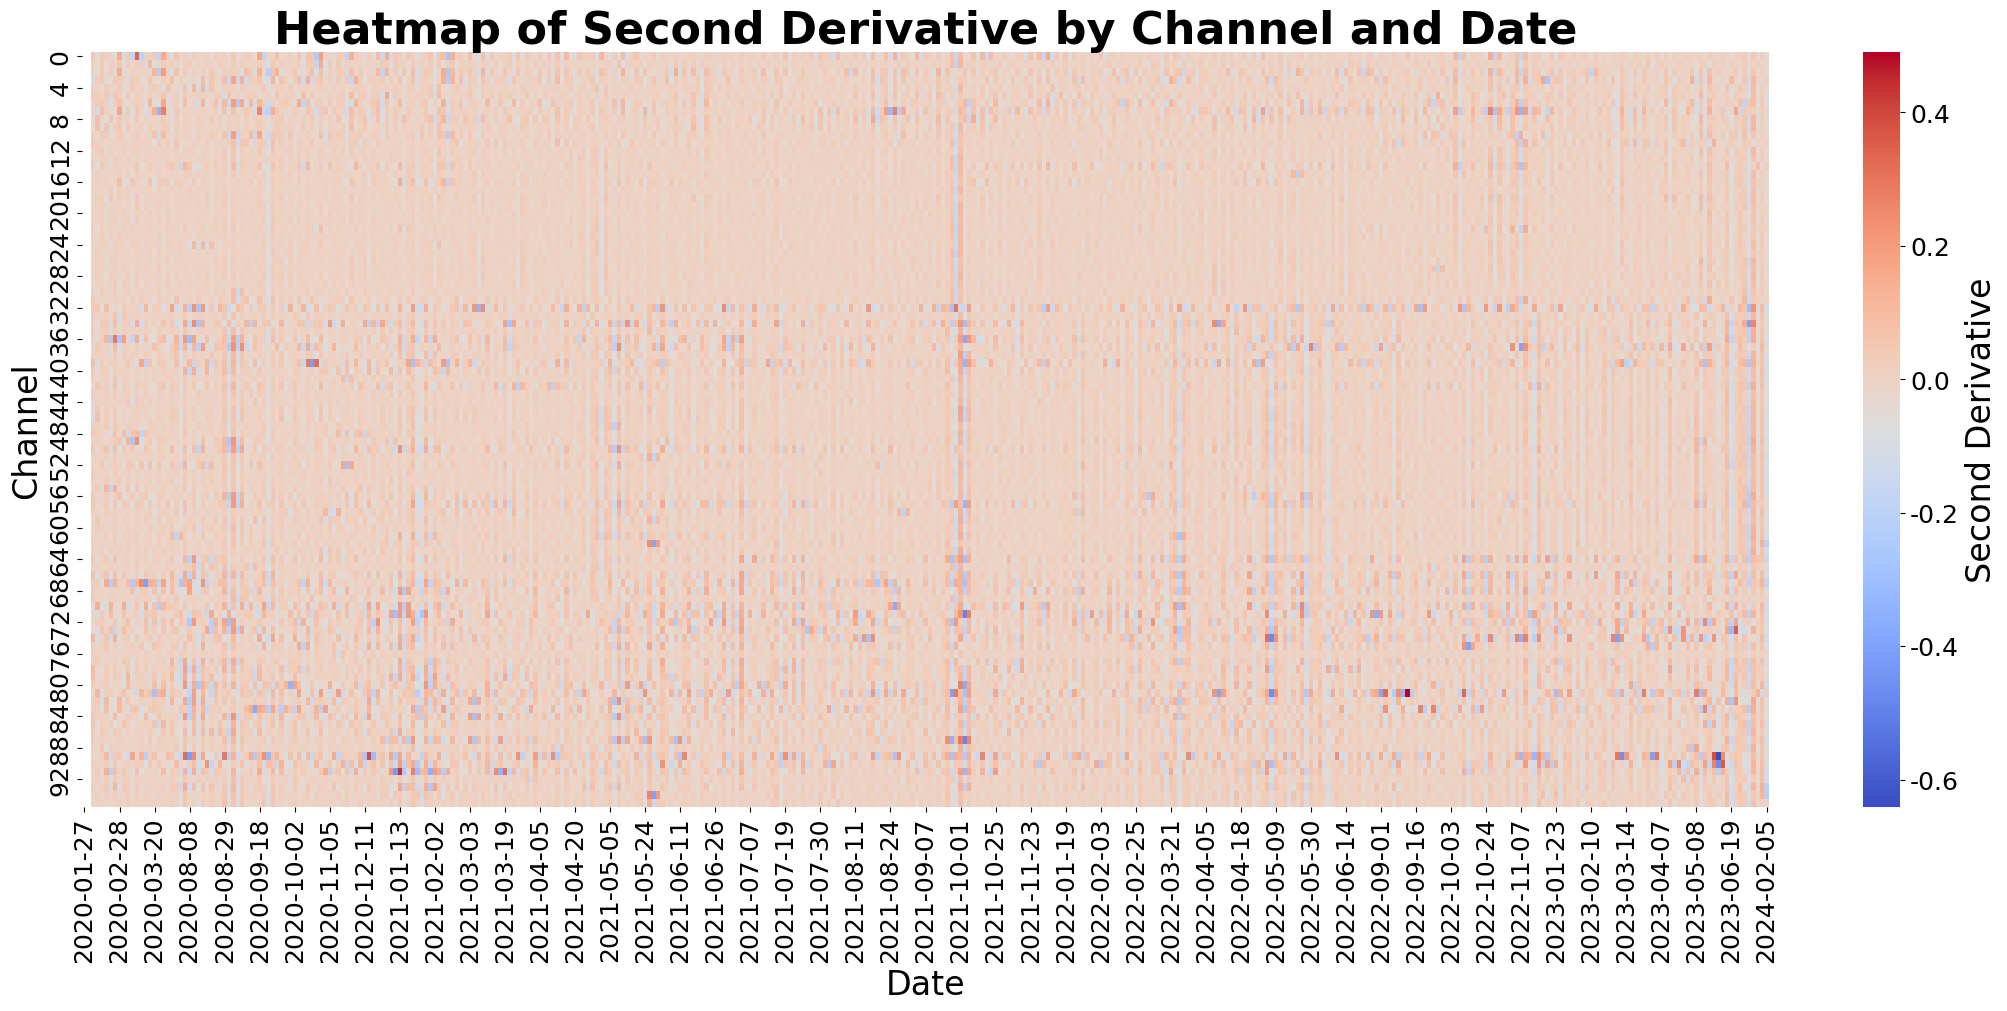

In [ ]:
second_derivative = matrix.diff(axis=1).diff(axis=1)
plt.figure(figsize=(20, 10))
sns.heatmap(second_derivative, cmap='coolwarm', cbar_kws={'label': 'Second Derivative'})
plt.title('Heatmap of Second Derivative by Channel and Date')
plt.xlabel('Date')
plt.ylabel('Channel')
plt.show()

C:\Users\chang\AppData\Local\Temp\ipykernel_17416\424825285.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


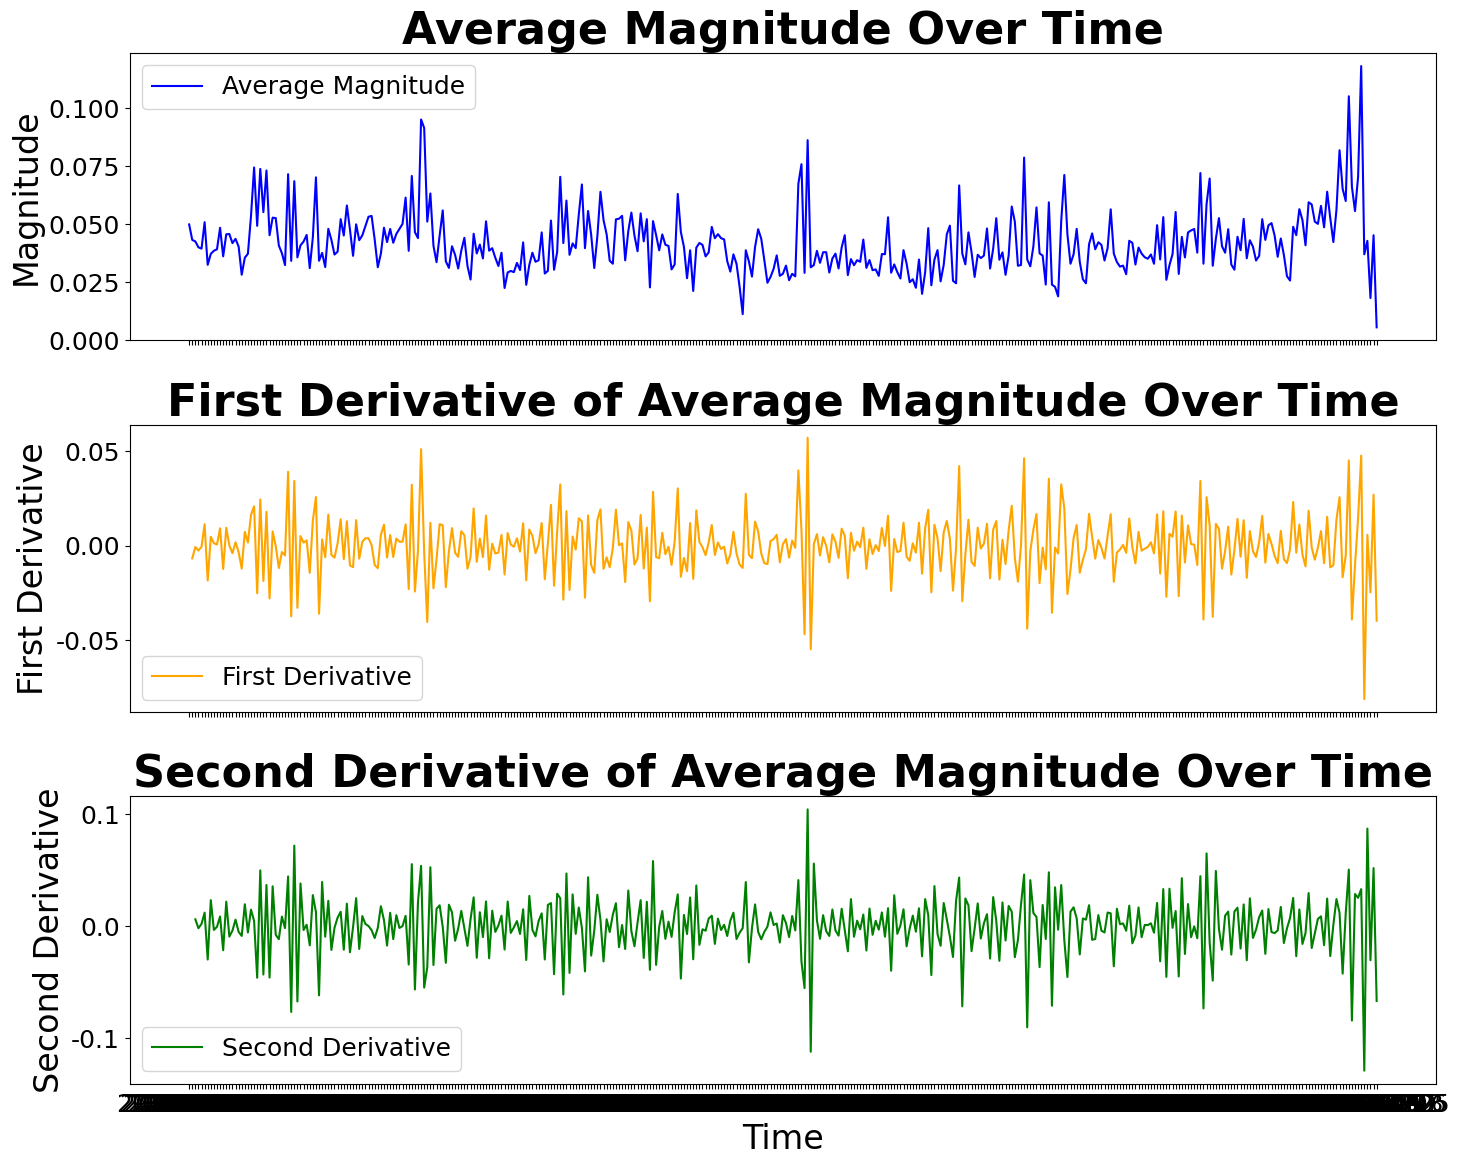

In [19]:
average_magnitude = matrix.mean(axis=0)
first_derivative_avg = average_magnitude.diff()
second_derivative_avg = first_derivative_avg.diff()

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

axes[0].plot(average_magnitude.index, average_magnitude, label='Average Magnitude', color='blue')
axes[0].set_title('Average Magnitude Over Time')
axes[0].set_ylabel('Magnitude')
axes[0].legend()

axes[1].plot(first_derivative_avg.index, first_derivative_avg, label='First Derivative', color='orange')
axes[1].set_title('First Derivative of Average Magnitude Over Time')
axes[1].set_ylabel('First Derivative')
axes[1].legend()

axes[2].plot(second_derivative_avg.index, second_derivative_avg, label='Second Derivative', color='green')
axes[2].set_title('Second Derivative of Average Magnitude Over Time')
axes[2].set_ylabel('Second Derivative')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()


C:\Users\chang\AppData\Local\Temp\ipykernel_17416\3688179099.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


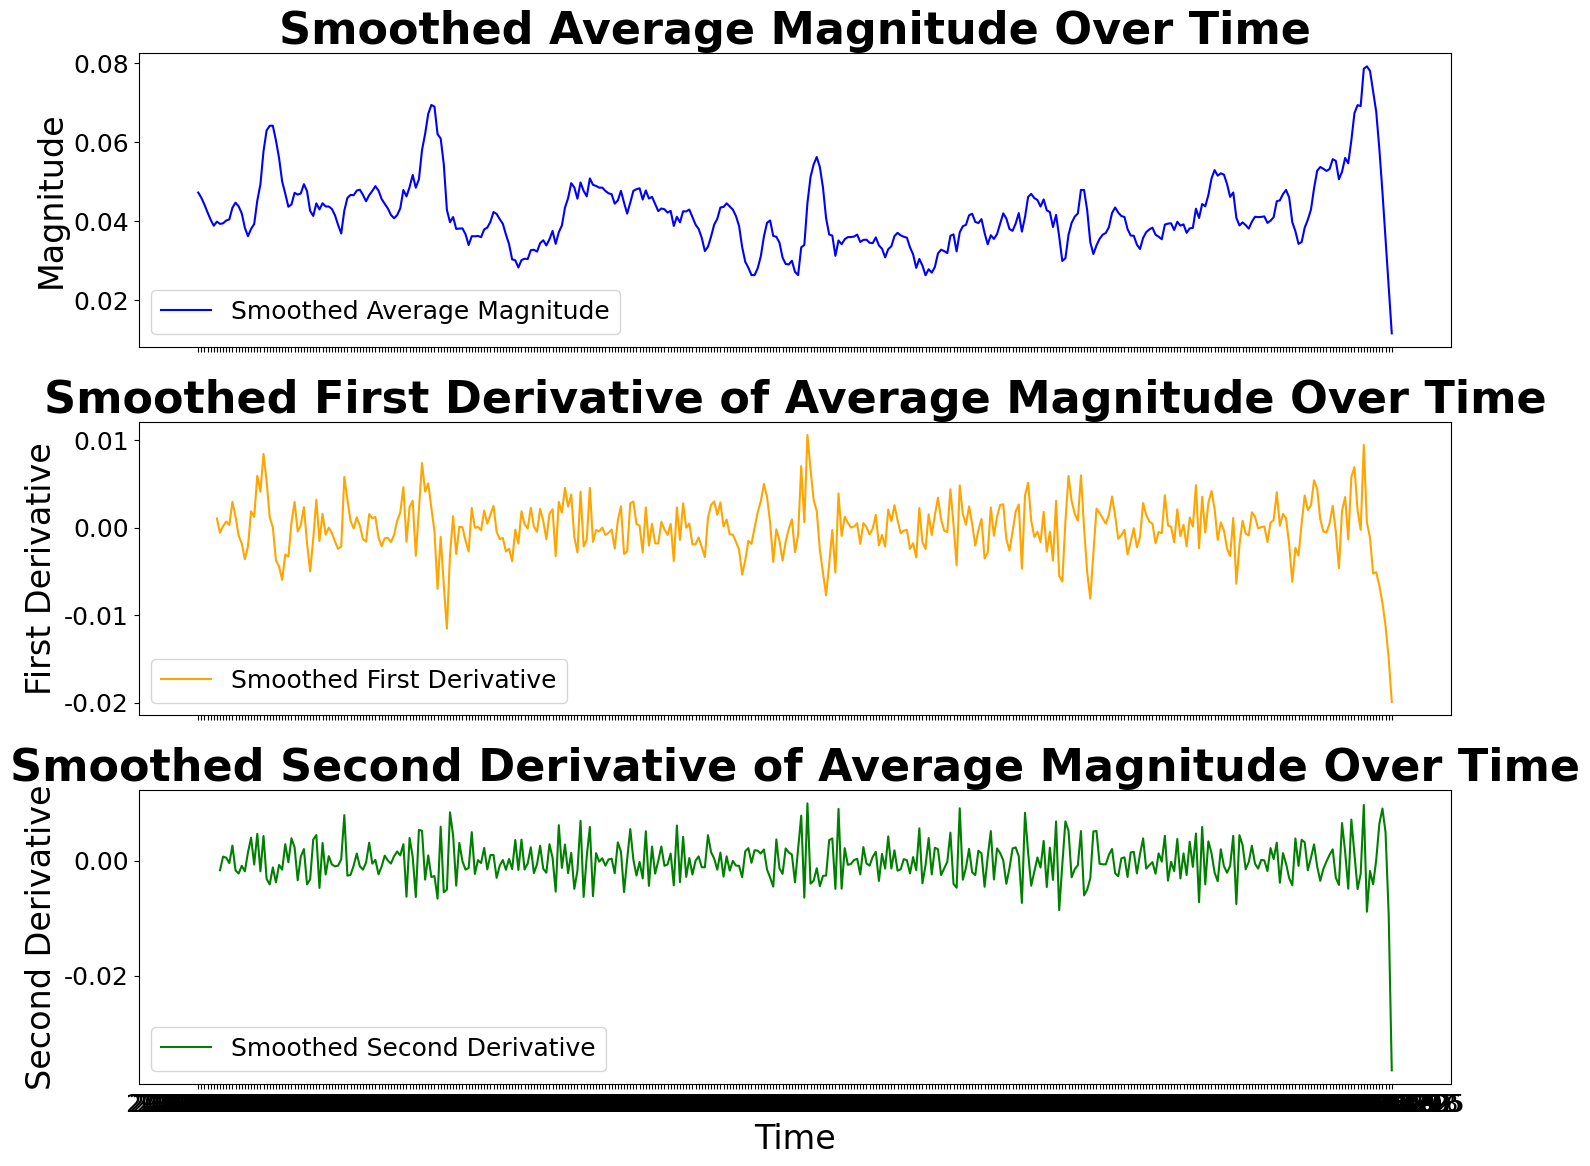

In [20]:
from scipy.signal import savgol_filter

smoothed_average_magnitude = savgol_filter(average_magnitude, window_length=11, polyorder=3)
smoothed_first_derivative_avg = savgol_filter(first_derivative_avg, window_length=11, polyorder=3)
smoothed_second_derivative_avg = savgol_filter(second_derivative_avg, window_length=11, polyorder=3)

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

axes[0].plot(average_magnitude.index, smoothed_average_magnitude, label='Smoothed Average Magnitude', color='blue')
axes[0].set_title('Smoothed Average Magnitude Over Time')
axes[0].set_ylabel('Magnitude')
axes[0].legend()

axes[1].plot(first_derivative_avg.index, smoothed_first_derivative_avg, label='Smoothed First Derivative', color='orange')
axes[1].set_title('Smoothed First Derivative of Average Magnitude Over Time')
axes[1].set_ylabel('First Derivative')
axes[1].legend()

axes[2].plot(second_derivative_avg.index, smoothed_second_derivative_avg, label='Smoothed Second Derivative', color='green')
axes[2].set_title('Smoothed Second Derivative of Average Magnitude Over Time')
axes[2].set_ylabel('Second Derivative')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()
